In [1]:
### The Side Kick ##

from langgraph.graph import StateGraph , START , END 
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from typing import Annotated , TypedDict , List , Any , Optional, Dict
from langchain_community.tools import DuckDuckGoSearchRun
from pydantic import BaseModel , Field
from langchain_core.messages import HumanMessage , SystemMessage ,AIMessage

d:\AI_agents_tutorial\ai_env\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [2]:
class EvaluatorOutput(BaseModel):
    feedback : str = Field(description = "Feedback on the assistant response")
    success_criteria_met : bool = Field(description =" whether the success criteria have been met")
    user_input_needed : bool = Field(description = "Whether more input is needed from the user to proceed")

In [3]:
class State(TypedDict):
    messages : Annotated[List[Any] , add_messages]
    user_input_needed : bool
    success_criteria_met : bool
    success_criteria : str
    feedback_on_work : Optional[str]


In [4]:
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool

ddg = DuckDuckGoSearchRun()

@tool
def search_tool(query :str)->str:
    """ Searches the web for the given query and returns the results"""
    result = ddg.invoke(query)
    return result


In [1]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os

load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")
llm  = ChatGroq(model = "openai/gpt-oss-120b" , groq_api_key = groq_api_key)



d:\AI_agents_tutorial\ai_env\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [6]:
tools  = [search_tool]
llm  = llm.bind_tools(tools)


In [7]:
evaluator_llm  = ChatGroq(model = "openai/gpt-oss-120b" , groq_api_key = groq_api_key)
evaluator_llm =  evaluator_llm.with_structured_output(EvaluatorOutput)

In [8]:
def worker(state: State) -> Dict[str, Any]:

    system_message = f"""
    You are a helpful assistant with tool usage ability.
    Success criteria:
    {state['success_criteria']}

    You must ask a question if you need clarification,
    or provide a final answer if criteria are met.
    """

    # If previous attempt failed
    if state.get("feedback_on_work"):
        system_message += f"""
        Previous attempt failed.
        Feedback: {state['feedback_on_work']}
        Improve your answer accordingly.
        """

    messages = state["messages"]

    # Insert system message only once
    if not any(isinstance(m, SystemMessage) for m in messages):
        messages = [SystemMessage(content=system_message)] + messages

    # Call LLM
    response = llm.invoke(messages)

    # RETURN AIMessage directly (!!! FIXED)
    return {"messages": [response]}

In [9]:
def worker_router(state : State) -> str:
    last_message = state['messages'][-1]
    if hasattr(last_message , "tool_calls") and last_message.tool_calls:
        return "tools"
    else:
        return "evaluator"
    
     

In [10]:
def format_conversation(messages :  List[Any]) ->str:
    conversation = "Conversation History : \n"
    for message in messages:
        if isinstance(message , HumanMessage):
            conversation += f"User : {message.content}\n"
        elif isinstance(message , AIMessage):
            text = message.content or "[Tool use]"
            conversation += f"Assistant : {text}\n"
    return conversation

In [11]:
def evaluator(state: State) -> State:
    last_response = state["messages"][-1].content

    system_message = "You are an evaluator that checks success criteria."
    user_message = f"""
    {format_conversation(state['messages'])}

    Success Criteria:
    {state['success_criteria']}

    Last Assistant Response:
    {last_response}
    """

    if state["feedback_on_work"]:
        user_message += f"\nPrevious feedback: {state['feedback_on_work']}\n"

    # FIXED: Not inside any wrong indentation
    evaluator_messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=user_message)
    ]
    eval_result = evaluator_llm.invoke(evaluator_messages)

    return {
        "messages": [AIMessage(content=f"Evaluator: {eval_result.feedback}")],
        "feedback_on_work": eval_result.feedback,
        "success_criteria_met": eval_result.success_criteria_met,
        "user_input_needed": eval_result.user_input_needed
    }

In [12]:
def route_based_on_evaluation(state : State)->str:
    if state['success_criteria_met'] or state['user_input_needed']:
        return "END"
    else:
        return "worker"
    

In [13]:
from langgraph.checkpoint.memory import MemorySaver
graph_builder =  StateGraph(State)
graph_builder.add_node("worker" , worker)
graph_builder.add_node("tools" , ToolNode(tools = tools))
graph_builder.add_node("evaluator" , evaluator)

graph_builder.add_conditional_edges("worker" , worker_router , {"tools" : "tools" , "evaluator" : "evaluator"})
graph_builder.add_edge("tools" , "worker")
graph_builder.add_conditional_edges("evaluator" , route_based_on_evaluation , {"END" : END , "worker" : "worker"})
graph_builder.add_edge(START , "worker")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer = memory)


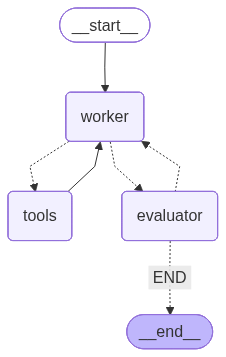

In [14]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
import uuid
def make_thread_id() -> str:
    return str(uuid.uuid4())


async def process_message(message, success_criteria, history, thread):

    config = {"configurable": {"thread_id": thread}}

    state = {
        "messages": message,
        "success_criteria": success_criteria,
        "feedback_on_work": None,
        "success_criteria_met": False,
        "user_input_needed": False
    }
    result = await graph.ainvoke(state, config=config)
    user = {"role": "user", "content": message}
    reply = {"role": "assistant", "content": result["messages"][-2].content}
    feedback = {"role": "assistant", "content": result["messages"][-1].content}
    return history + [user, reply, feedback]

async def reset():
    return "", "", None, make_thread_id()

In [16]:
import gradio as gr

with gr.Blocks() as demo:
    gr.Markdown("## Sidekick Personal Co-worker")
    thread = gr.State(make_thread_id())
    
    with gr.Row():
        chatbot = gr.Chatbot(label="Sidekick", height=300)

    with gr.Group():
        with gr.Row():
            message = gr.Textbox(show_label=False, placeholder="Your request to your sidekick")
        with gr.Row():
            success_criteria = gr.Textbox(show_label=False, placeholder="What are your success criteria?")

    with gr.Row():
        reset_button = gr.Button("Reset", variant="stop")
        go_button = gr.Button("Go!", variant="primary")

    message.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    success_criteria.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    go_button.click(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    reset_button.click(reset, [], [message, success_criteria, chatbot, thread])

demo.launch(theme=gr.themes.Default(primary_hue="emerald"))


d:\AI_agents_tutorial\ai_env\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
